## How to build CNN in TensorFlow: examples, code, and notebooks

Click the image below to read the post online.

<a target="_blank" href="https://www.machinelearningnuggets.com/cnn-tensorflow
"><img src="https://www.machinelearningnuggets.com/ezoimgfmt/digitalpress.fra1.cdn.digitaloceanspaces.com/mhujhsj/2022/07/logho-1.png?ezimgfmt=ng:webp/ngcb1" alt="Open in ML Nuggets"></a>

In [ ]:
pip install -U tensorboard-plugin-profile

In [ ]:
pip install wget

In [ ]:
import wget # pip install wget
import tarfile
wget.download("http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz")
food_tar = tarfile.open('food-101.tar.gz')
food_tar.extractall('.') 
food_tar.close()

(-0.5, 511.5, 511.5, -0.5)

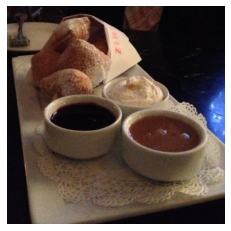

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
plt.imshow(Image.open("food-101/images/beignets/2802124.jpg"))
plt.axis('off')

In [18]:
base_dir = 'food-101/images'

## Generate a tf.data.Dataset

In [19]:
batch_size = 32
img_height = 128
img_width = 128

In [20]:
import tensorflow as tf
training_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


In [21]:
validation_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [22]:
class_names = training_set.class_names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

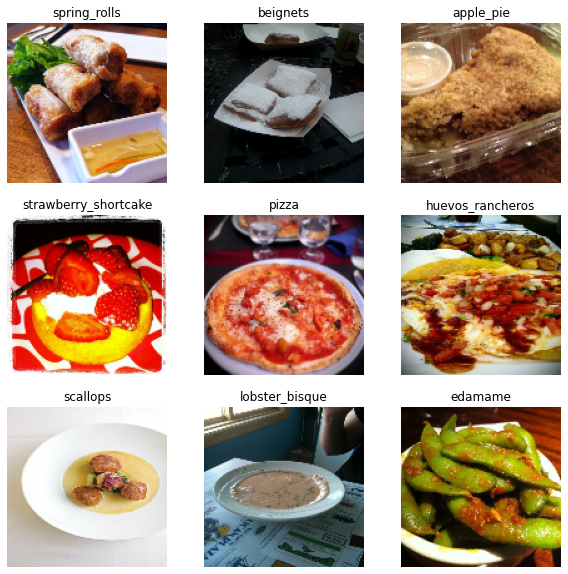

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
image_iterator = iter(training_set)
image_batch, labels_batch = image_iterator.get_next()

In [25]:
print(image_batch.shape)
print(labels_batch.shape)

(32, 128, 128, 3)
(32,)


## Configure the dataset for performance

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

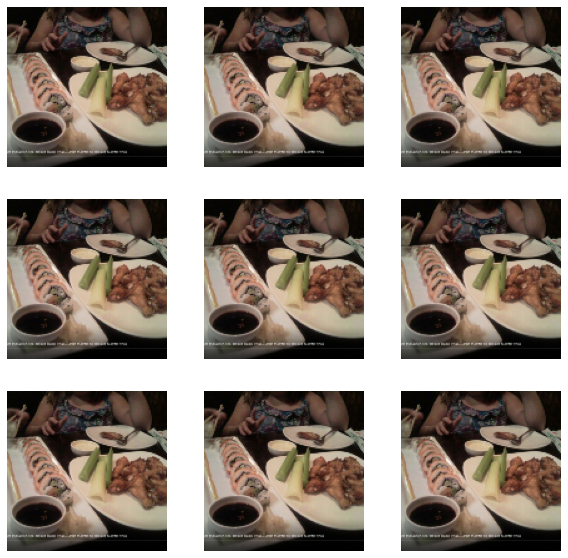

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in training_set.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model definition

In [ ]:
model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(len(class_names), activation='softmax')])

## Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

## Training the model

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs=100

In [ ]:
history = model.fit(image_batch, labels_batch,validation_split=0.2, epochs=epochs,callbacks=[callback])
# uncomment this line to train on the entire dataset, it's a large dataset, so confirm that you have sufficient RAM. 
# history = model.fit(training_set,validation_data=validation_set, epochs=epochs,callbacks=[callback])

## Model evaluation

In [ ]:
loss, accuracy = model.evaluate(validation_set)
print('Accuracy on test dataset:', accuracy)

## Monitoring the model’s performance

In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(history.history)
loss, accuracy = model.evaluate(validation_set)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();

## Visualize CNN with TensorBoard

In [ ]:
log_folder ="logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder, 
                                                      histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])
model.fit(training_set,validation_data=validation_set,epochs=2, callbacks=[tensorboard_callback])

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir={log_folder}

## How to profile with TensorBoard

In [ ]:
# pip install -U tensorboard-plugin-profile

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_folder, profile_batch='2,5', update_freq=1)
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])
# model.fit(training_set,validation_data=validation_set,epochs=2, callbacks=[tensorboard_callback])
history = model.fit(image_batch, labels_batch,validation_split=0.2, epochs=3,callbacks=[tensorboard_callback])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_folder}

## Make predictions on new images

In [32]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/b/b1/Buttermilk_Beignets_%284515741642%29.jpg"
image_path = tf.keras.utils.get_file('Sample_Food', origin=image_url)

1531904/1522364 [==============================] - 0s 0us/step


In [33]:
test_image = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(test_image)
img_array = tf.expand_dims(img_array, 0) 

In [34]:
img_array = img_array / 255.0

In [ ]:
prediction = model.predict(img_array)

In [ ]:
prediction[0][0]

In [ ]:
import tensorflow as tf
import numpy as np
scores = tf.nn.softmax(prediction[0])
scores = scores.numpy()

In [ ]:
f"{class_names[np.argmax(scores)]} with a { (100 * np.max(scores)).round(2) } percent confidence." 

# Architectures

# Model without weights

In [29]:
model = tf.keras.applications.ResNet152(
    include_top=True,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

242909184/242900224 [==============================] - 4s 0us/step


In [37]:
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
test_image = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(test_image)
img_array = tf.expand_dims(img_array, 0) 
x = preprocess_input(img_array)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n07836838', 'chocolate_sauce', 0.4584937), ('n07693725', 'bagel', 0.2302542), ('n07695742', 'pretzel', 0.18161112)]


In [30]:
model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

# Model with Weights

In [31]:
model = tf.keras.applications.ResNet152(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

## Where to go from here
Follow us on [LinkedIn](https://www.linkedin.com/company/mlnuggets), [Twitter](https://twitter.com/ml_nuggets), [GitHub](https://github.com/mlnuggets) and subscribe to our [blog](https://www.machinelearningnuggets.com/#/portal) so that you don't miss a new issue.